In [48]:
%matplotlib widget 
#%load_ext autoreload
#%autoreload 2
%load_ext tensorboard 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
import sys
import os

# Add the directory containing the ai_badminton package to the Python path
sys.path.append(os.path.abspath('./ai-badminton/src/ai_badminton'))
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.trajectory import Trajectory
from ai_badminton.video_annotator import annotate_video

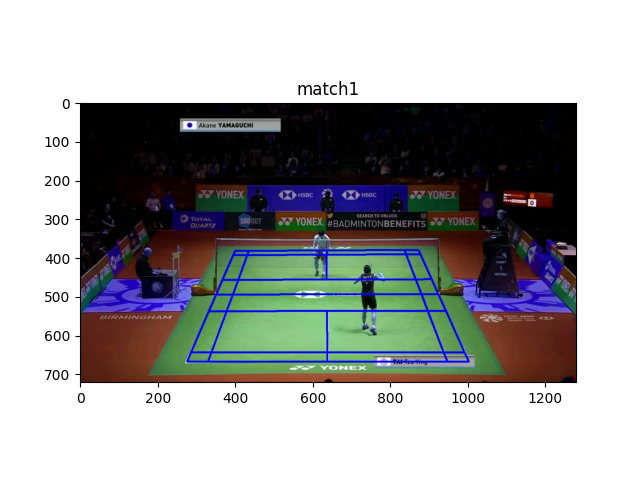

In [50]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

data_dir = "C:\data"
#matches = list('match' + str(i) for i in range(1, 27)) + list('test_match' + str(i) for i in range(1, 4))
for video in os.listdir(f'{data_dir}/match1/rally_video/'):
    rally, _ = os.path.splitext(video)
    
    def read_court(filename):
        # Open the file and read the first four lines
        with open(filename, "r") as file:
            lines = file.readlines()
        # Extract the first four lines (court corner coordinates)
        corners = []
        for i in range(4):  # Read only the first four lines
            x, y = map(float, lines[i].strip().split(";"))  # Convert to float
            corners.append((x, y))  # Store as (x, y) tuple
        return corners

    court_pts = read_court(f'{data_dir}/match1/court/%s.txt' % (rally))
    corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]

    def draw_court(corners):
        # Draws the court once we have the three corners
        court = Court(corners)
        frames[-1] = court.draw_lines(frames[-1])
        plt.imshow(frames[-1])
        plt.title("match1")

    cap = cv2.VideoCapture(f'{data_dir}/match1/rally_video/%s.mp4' % (rally))
    if cap.isOpened() is False:
        print('Error opening video stream or file')

    ret, frame = cap.read()
    fig = plt.figure()
    frames = [frame]

    draw_court(corners)
    break
court = Court(corners)

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

data_dir = "C:\data"
matches = list('match' + str(i) for i in range(1, 27)) + list('test_match' + str(i) for i in range(1, 4))
for match in matches:
    for video in os.listdir(f'{data_dir}/%s/rally_video/' % match):
        rally, _ = os.path.splitext(video)
        
        court_pts = read_court(f'{data_dir}/%s/court/%s.out' % (match, rally))
        corners = [court_pts[1], court_pts[2], court_pts[0], court_pts[3]]
    
        def draw_court(corners):
            # Draws the court once we have the three corners
            court = Court(corners)
            frames[-1] = court.draw_lines(frames[-1])
            plt.imshow(frames[-1])
            plt.title(match)
   
        cap = cv2.VideoCapture(f'{data_dir}/%s/rally_video/%s.mp4' % (match, rally))
        if cap.isOpened() is False:
            print('Error opening video stream or file')

        ret, frame = cap.read()
        fig = plt.figure()
        frames = [frame]

        draw_court(corners)
        break
court = Court(corners)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\data/match1/court/rally1.out'

# Data preparation

In [65]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

import os
import pandas as pd
import numpy as np
import cv2
import random
from scipy.stats import mode
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale, resize

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

def visualize(x, y):
    print(x.shape, y.shape)
    cdict = {0: 'red', 1: 'blue', 2: 'green'}
    plt.figure()
    for g in np.unique(y):
        ix = np.where(y == g)
        plt.scatter(*x[ix, -4:, :].T, c=cdict[g], label=g)
        plt.scatter(*x[ix, 0, :].T, c=cdict[g], label=g)
    plt.show()
    
def resample(series, s):
    flatten = False
    if len(series.shape) == 1:
        series.resize((series.shape[0], 1))
        series = series.astype('float64')
        flatten = True
    series = resize(
        series, (int(s * series.shape[0]), series.shape[1]),
    )
    if flatten:
        series = series.flatten()
    return series   

eps = 1e-6
def reflect(x):
    x = np.array(x)
    idx = np.abs(x) < eps
    for i in range(0, x.shape[1], 2):
        x[:, i] = -x[:, i]
    x[idx] = 0.
    return x

# Identify first hit by distance to pose
# and then alternate hits
def dist_to_pose(pose, p):
    pose = pose.reshape(15, 2) # 17->15 keypoints
    p = p.reshape(1, 2)
    D = np.sum((pose - p) * (pose - p), axis=1)
    return min(D)

def scale_data(x):
    x = np.array(x)
    def scale_by_col(x, cols):
        x_ = np.array(x[:, cols])
        idx = np.abs(x_) < eps
        m, M = np.min(x_[~idx]), np.max(x_[~idx])
        x_[~idx] = (x_[~idx] - m) / (M - m) + 1
        x[:, cols] = x_
        return x

    even_cols = [2*i for i in range(x.shape[1] // 2)]
    odd_cols = [2*i+1 for i in range(x.shape[1] // 2)]
    x = scale_by_col(x, even_cols)
    x = scale_by_col(x, odd_cols)
    return x

identity = lambda x: x
def drop_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        x[i][max(0, 78*(j-2)):min(78*(j+2), 78*num_consec)] = rep_value
    return x

def corrupt_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        l, r = max(0, 78*(j-2)), min(78*(j+2), 78*num_consec)
        x[i][l:r] = np.random.rand(1, r-l)
    return x

def drop_data(x, rep_value=0, keep_prob=0.95):
    x = np.array(x)
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    x[np.unravel_index(indices, x.shape)] = rep_value
    return x

def corrupt_data(x, keep_prob=0.95):
    x = np.array(x)
    idx = np.abs(x) < eps
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    shape = x[np.unravel_index(indices, x.shape)].shape
    low, hi = max(np.min(x[:,0::2]), np.min(x[:,1::2])), min(np.max(x[:,0::2]), np.max(x[:,1::2]))
    target = np.random.rand(*shape) * (hi-low) + low
    x[np.unravel_index(indices, x.shape)] = target
    x[idx] = 0.
    return x

def jiggle_and_rotate(x):
    # Randomly shift by a vector in [0, 30]
    # and rotate by a random amount between -10 and 10 degrees
    x = np.array(x.reshape((x.shape[0], x.shape[1] // 2, 2)))
    idx = np.abs(x) < eps
    # shift does nothing when we rescale after
    # shift = np.random.rand(1, 2) * 30
    angle = (np.random.rand() - 0.5) * math.pi / 180 * 30
    rotate = np.array([[math.cos(angle), -math.sin(angle)], 
                       [math.sin(angle), math.cos(angle)]])
    a, b = np.random.rand() * 0.1, np.random.rand() * 0.1
    shear = np.array([[1+a*b, a], 
                      [b,     1]])
    x = x @ shear @ rotate
    x[idx] = 0.
    x = x.reshape((x.shape[0], x.shape[1] * 2))
    return x

drop_random_and_jiggle = lambda x: drop_data(jiggle_and_rotate(x), 0, 0.95)
corrupt_random_and_jiggle = lambda x: corrupt_data(jiggle_and_rotate(x), 0.95)
drop_consecutive_and_jiggle = lambda x: drop_consecutive(jiggle_and_rotate(x))
corrupt_consecutive_and_jiggle = lambda x: corrupt_consecutive(jiggle_and_rotate(x))

C:\Users\User\AppData\Local\Temp\ipykernel_12092\2589351127.py:17: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [66]:
num_consec = 12 # Jui: read the paper for the correct parameters
left_window = 6
right_window = 0
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

manual_label = {
    ('match1', '1_02_04'): 2,
    ('match1', '1_06_08'): 1,
    ('match1', '1_02_02'): 1,
    ('match1', '1_02_01'): 2,
    ('match1', '1_03_04'): 2,
    ('match1', '1_02_03'): 1,
    ('match3', '1_08_10'): 2,
    ('match8', '3_02_00'): 2,
}

x_train, y_train = [], []

basedir = f'{data_dir}\\match1' 
for video in os.listdir('%s/rally_video/' % basedir):
    if '.mp4' not in video:
        print('Skipping', video)
        continue
    for speed in [1.0]:#[0.833, 0.9, 1.0, 1.1, 1.2]:
        rally, _ = os.path.splitext(video)
        trajectory = Trajectory(
            r"C:\data\match1\ball_tracjectory\rally1_ball_predicted.csv",
            interp=False
        )
        hit = pd.read_csv('%s/shot/%s_hit.csv' % (basedir, rally))
        poses = read_player_poses(os.path.join(r"C:\data\match1\poses", rally + "\\"))
        
        bottom_player, top_player = poses[0], poses[1]

        def read_court(filename):
            # Open the file and read the first four lines
            with open(filename, "r") as file:
                lines = file.readlines()
            # Extract the first four lines (court corner coordinates)
            corners = []
            for i in range(4):  # Read only the first four lines
                x, y = map(float, lines[i].strip().split(";"))  # Convert to float
                corners.append((x, y))  # Store as (x, y) tuple
            return corners
    
        x_list, y_list = [], []
        court_pts = read_court(f'{data_dir}/match1/court/%s.txt' % (rally))
        corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
        
        cap = cv2.VideoCapture('%s/rally_video/%s' % (basedir, video))
        _, frame = cap.read()
        height, width = frame.shape[:2]         
        
        hit = hit.values[:, 1]
        if speed < 1:
            # NTS: speed < 1 actually means sequence gets faster
            hit = hit + shift(hit, -1) + shift(hit, +1)
                    
        trajectory.X = resample(np.array(trajectory.X), speed)
        trajectory.Y = resample(np.array(trajectory.Y), speed)
        hit = resample(hit, speed).round()
        bottom_player = resample(bottom_player.values, speed)
        top_player = resample(top_player.values, speed)
        
        y_new = np.array(hit)
        if speed != 1:
            for i in range(y_new.shape[0] - 1):
                if i+3 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2] and y_new[i+3]:
                    y_new[i] = y_new[i+1] = y_new[i+3] = 0.
                if i+2 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2]:
                    y_new[i] = y_new[i+2] = 0.
                if y_new[i] and y_new[i+1]:
                    y_new[i] = 0.
                    
        # Majority vote for who started the rally
        # If hit number is odd, then whoever started the rally
        # is the opposite of whoever was detected.
        votes = [0, 0]
        best_dist = [1e99, 1e99]
        nhit = 0
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            p = np.array([trajectory.X[i], trajectory.Y[i]])
            db = dist_to_pose(bottom_player[i], p)
            dt = dist_to_pose(top_player[i], p)
            person = 0
            if db < dt:
                person = 1
            else:
                person = 2

            if nhit % 2:
                person = 3 - person

            votes[person - 1] += 1
            best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

            nhit += 1

        if abs(votes[0] - votes[1]) < 2:
            print(match, rally, 'is hard', votes, best_dist)
        else:
            print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

        last = 2 if votes[0] > votes[1] else 1
        if (match, rally) in manual_label:
            last = 3 - manual_label[match, rally]
            print('Manual label applied.')
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            y_new[i] = 3 - last
            last = y_new[i]
            
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

            # Use entire pose
            x_pose = np.hstack([bottom_player[i:end], top_player[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)

        x_t = np.hstack(x_list)
        if right_window > 0:
            y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
        else:
            y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)
                
        # y_t = np.column_stack(y_list).astype('float')
        # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
        # for i in range(y_t.shape[0]):
        #     val, cnt = np.unique(y_t[i], return_counts=True)
        #     val = val.astype('int')
        #     cnt = cnt.astype('float')
        #     y_t[i, 0:3] = 0
        #     y_t[i, val] = cnt / subwindow_size
        # y_t = y_t[:, :3]

        augmentations = [identity]# + [jiggle_and_rotate]*2# + [drop_consecutive_and_jiggle] + [corrupt_consecutive_and_jiggle]
        #+ [corrupt_and_jiggle] + [drop_and_jiggle]# + [jiggle_and_rotate] + [drop_and_jiggle] + [corrupt_and_jiggle]
        for transform in augmentations:
            x_train.append(scale_data(transform(x_t)))
            y_train.append(y_t)
            
            # x_train.append(scale_data(transform(reflect(x_t))))
            # y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

match1 rally1 2 [6, 12]


## Training data

In [4]:
num_consec = 12 # Jui: read the paper for the correct parameters
left_window = 6
right_window = 0
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

manual_label = {
    ('match1', '1_02_04'): 2,
    ('match1', '1_06_08'): 1,
    ('match1', '1_02_02'): 1,
    ('match1', '1_02_01'): 2,
    ('match1', '1_03_04'): 2,
    ('match1', '1_02_03'): 1,
    ('match3', '1_08_10'): 2,
    ('match8', '3_02_00'): 2,
}

x_train, y_train = [], []
for match in matches:
    basedir = f'{data_dir}/%s' % match
    for video in os.listdir('%s/rally_video/' % basedir):
        if '.mp4' not in video:
            continue
        for speed in [1.0]:#[0.833, 0.9, 1.0, 1.1, 1.2]:
            rally, _ = os.path.splitext(video)
            trajectory = Trajectory(
                '%s/ball_trajectory/%s_ball_predicted.csv' % (basedir, rally),
                interp=False
            )
            hit = pd.read_csv('%s/shot/%s_hit.csv' % (basedir, rally))

            poses = read_player_poses('%s/poses/%s' % (basedir, rally))
            bottom_player, top_player = poses[0], poses[1]

            x_list, y_list = [], []
            court_pts = read_court('%s/court/%s.out' % (basedir, rally))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            
            cap = cv2.VideoCapture('%s/rally_video/%s' % (basedir, video))
            _, frame = cap.read()
            height, width = frame.shape[:2]         
            
            hit = hit.values[:, 1]
            if speed < 1:
                # NTS: speed < 1 actually means sequence gets faster
                hit = hit + shift(hit, -1) + shift(hit, +1)
                        
            trajectory.X = resample(np.array(trajectory.X), speed)
            trajectory.Y = resample(np.array(trajectory.Y), speed)
            hit = resample(hit, speed).round()
            bottom_player = resample(bottom_player.values, speed)
            top_player = resample(top_player.values, speed)
            
            y_new = np.array(hit)
            if speed != 1:
                for i in range(y_new.shape[0] - 1):
                    if i+3 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2] and y_new[i+3]:
                        y_new[i] = y_new[i+1] = y_new[i+3] = 0.
                    if i+2 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2]:
                        y_new[i] = y_new[i+2] = 0.
                    if y_new[i] and y_new[i+1]:
                        y_new[i] = 0.
                        
            # Majority vote for who started the rally
            # If hit number is odd, then whoever started the rally
            # is the opposite of whoever was detected.
            votes = [0, 0]
            best_dist = [1e99, 1e99]
            nhit = 0
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                p = np.array([trajectory.X[i], trajectory.Y[i]])
                db = dist_to_pose(bottom_player[i], p)
                dt = dist_to_pose(top_player[i], p)
                person = 0
                if db < dt:
                    person = 1
                else:
                    person = 2

                if nhit % 2:
                    person = 3 - person

                votes[person - 1] += 1
                best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

                nhit += 1

            if abs(votes[0] - votes[1]) < 2:
                print(match, rally, 'is hard', votes, best_dist)
            else:
                print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

            last = 2 if votes[0] > votes[1] else 1
            if (match, rally) in manual_label:
                last = 3 - manual_label[match, rally]
                print('Manual label applied.')
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                y_new[i] = 3 - last
                last = y_new[i]
                
            for i in range(num_consec):
                end = min(len(trajectory.X), len(hit))-num_consec+i+1
                x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

                # Use entire pose
                x_pose = np.hstack([bottom_player[i:end], top_player[i:end]])
                x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
                y = y_new[i:end]
                x_list.append(x)
                y_list.append(y)

            x_t = np.hstack(x_list)
            if right_window > 0:
                y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
            else:
                y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)
                    
            # y_t = np.column_stack(y_list).astype('float')
            # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
            # for i in range(y_t.shape[0]):
            #     val, cnt = np.unique(y_t[i], return_counts=True)
            #     val = val.astype('int')
            #     cnt = cnt.astype('float')
            #     y_t[i, 0:3] = 0
            #     y_t[i, val] = cnt / subwindow_size
            # y_t = y_t[:, :3]

            augmentations = [identity]# + [jiggle_and_rotate]*2# + [drop_consecutive_and_jiggle] + [corrupt_consecutive_and_jiggle]
            #+ [corrupt_and_jiggle] + [drop_and_jiggle]# + [jiggle_and_rotate] + [drop_and_jiggle] + [corrupt_and_jiggle]
            for transform in augmentations:
                x_train.append(scale_data(transform(x_t)))
                y_train.append(y_t)
                
                # x_train.append(scale_data(transform(reflect(x_t))))
                # y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

NameError: name 'data_dir' is not defined

## Validation data

In [42]:
from pathlib import Path
# Get validation data
x_val, y_val = [], []
base_dir = Path(data_dir)
for match_dir in base_dir.iterdir():
    if 'test_match' not in str(match_dir):
        continue
    rally_video_path = match_dir / "rally_video"

    for video_path in rally_video_path.iterdir():
        try:
            print(f"Fetching video: {str(video_path)}")
            stem = video_path.stem
            trajectory_path = match_dir / "ball_trajectory" / (stem + "_ball_predicted.csv")
            hit_path = match_dir / "shot" / (stem + "_hit.csv")
            court_path = match_dir / "court" / (stem + ".out")
            poses_path_prefix = match_dir / "poses" / stem

            poses_bottom_path = Path(str(poses_path_prefix) + "_player_bottom.csv") 
            poses_top_path = Path(str(poses_path_prefix) + "_player_top.csv") 

            assert trajectory_path.is_file(), f"Trajectory file does not exist for: {video_path}"
            assert hit_path.is_file(), f"Hit file does not exist for: {video_path}"
            assert court_path.is_file(), f"Court file does not exist for: {video_path}"
            assert poses_bottom_path.is_file(), f"Bottom pose file does not exist for: {video_path}"
            assert poses_top_path.is_file(), f"Top pose file does not exist for: {video_path}"

            trajectory = Trajectory(str(trajectory_path), interp=False)
            hit = pd.read_csv(str(hit_path))
            poses = read_player_poses(str(poses_path_prefix))
            bottom_player, top_player = poses[0], poses[1]
            court_pts = read_court(str(court_path))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            cap = cv2.VideoCapture(str(video_path))
            _, frame = cap.read()
            height, width = frame.shape[:2]
        except:
            print('Failed data fetch for video:', str(video_path))
            continue
        
        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)

        y_new = np.array(hit.hit.to_numpy())
        # Majority vote for who started the rally
        # If hit number is odd, then whoever started the rally
        # is the opposite of whoever was detected.
        votes = [0, 0]
        best_dist = [1e99, 1e99]
        nhit = 0
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            p = np.array([trajectory.X[i], trajectory.Y[i]])
            db = dist_to_pose(bottom_player.values[i], p)
            dt = dist_to_pose(top_player.values[i], p)
            person = 0
            if db < dt:
                person = 1
            else:
                person = 2

            if nhit % 2:
                person = 3 - person

            votes[person - 1] += 1
            best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

            nhit += 1

        if abs(votes[0] - votes[1]) < 2:
            print(rally_video_path / video_path, 'is hard', votes, best_dist)
        else:
            print(rally_video_path / video_path, 1 if votes[0] > votes[1] else 2, votes)

        last = 2 if votes[0] > votes[1] else 1
        if votes[0] == votes[1]:
            last = 1 if best_dist[0] < best_dist[1] else 2

        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            y_new[i] = 3 - last
            last = y_new[i]

        # last = 0
        # last_id = -1
        # for i in range(y_new.shape[0]):
        #     if y_new[i] > 0:
        #         if last_id >= 0:
        #             for j in range(last_id, i):
        #                 y_new[j] = last
        #         last = y_new[i]
        #         last_id = i
        #     y_new[i] = last

        x_list = []
        y_list = []
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)
            
        x_t = np.hstack(x_list)
        if right_window > 0:
            y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
        else:
            y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)

            
        # y_t = np.column_stack(y_list).astype('float')
        # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
        # for i in range(y_t.shape[0]):
        #     val, cnt = np.unique(y_t[i], return_counts=True)
        #     val = val.astype('int')
        #     cnt = cnt.astype('float')
        #     y_t[i, 0:3] = 0
        #     y_t[i, val] = cnt / subwindow_size
        # y_t = y_t[:, :3]

        x_val.append(scale_data(x_t))
        y_val.append(y_t)

x_val = np.vstack(x_val)
y_val = np.hstack(y_val)

Fetching video: /home/work_space/data/test_match1/rally_video/1_09_07.mp4
/home/work_space/data/test_match1/rally_video/1_09_07.mp4 1 [20, 3]
Fetching video: /home/work_space/data/test_match1/rally_video/1_07_06.mp4
/home/work_space/data/test_match1/rally_video/1_07_06.mp4 is hard [5, 6] [1689.2631038501008, 1808.8286952228966]
Fetching video: /home/work_space/data/test_match1/rally_video/1_06_03.mp4
/home/work_space/data/test_match1/rally_video/1_06_03.mp4 2 [4, 8]
Fetching video: /home/work_space/data/test_match1/rally_video/1_05_02.mp4
/home/work_space/data/test_match1/rally_video/1_05_02.mp4 1 [13, 3]
Fetching video: /home/work_space/data/test_match1/rally_video/2_03_10.mp4
/home/work_space/data/test_match1/rally_video/2_03_10.mp4 1 [18, 1]
Fetching video: /home/work_space/data/test_match1/rally_video/1_07_03.mp4
/home/work_space/data/test_match1/rally_video/1_07_03.mp4 1 [19, 4]
Fetching video: /home/work_space/data/test_match1/rally_video/2_03_08.mp4
/home/work_space/data/test_ma

# Hitnet training with automatic hyperparameter tuning

In [43]:
# Subsample the training and validation to have 50/50 hit events and non-hit events
# (otherwise we can get high accuracy trivially from the nonhit events)
import random

p = sum(y_train > 0) / sum(y_train == 0)
subsample = []
for i in range(x_train.shape[0]):
    if random.random() < p or y_train[i]:
        subsample.append(i)
        
x_train = x_train[subsample]
y_train = y_train[subsample]

In [44]:
p = sum(y_val > 0) / sum(y_val == 0)
subsample = []
for i in range(x_val.shape[0]):
    if random.random() < p or y_val[i]:
        subsample.append(i)
        
x_val = x_val[subsample]
y_val = y_val[subsample]

In [45]:
import gc
gc.collect()

2022-09-17 20:14:18.834825: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_2 in the registry.


2022-09-17 20:14:18.834939: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_2 in the registry.


	 [[{{node PyFunc}}]]

178022

In [46]:
# Use tensorflow's dataset function to do augmentation on the fly
choices = [identity, 
           drop_consecutive, 
           drop_data, 
           corrupt_consecutive, 
           corrupt_data, 
           jiggle_and_rotate, 
           drop_random_and_jiggle, 
           corrupt_random_and_jiggle, 
           drop_consecutive_and_jiggle,
           corrupt_consecutive_and_jiggle]
probs = [2, 1, 1, 1, 1, 5, 1, 1, 9, 9]
probs = [x / sum(probs) for x in probs]

def augment(x):
    aug = np.random.choice(choices, p=probs)
    if random.random() < 0.5:
        x = reflect(x)
    return scale_data(aug(x))

BATCH_SIZE = 64
def fetch_data(batch_size=BATCH_SIZE):
    global x_train, y_train
    while True:
        idx = np.random.permutation(x_train.shape[0])
        x_train, y_train = x_train[idx], y_train[idx]
        for i in range(0, x_train.shape[0], BATCH_SIZE):
            yield augment(x_train[i:i+BATCH_SIZE]), y_train[i:i+BATCH_SIZE]
        
dataset = tf.data.Dataset.from_generator(
    fetch_data,
    output_shapes=((None, x_train.shape[1]), (None,)),
    output_types=(tf.float32, tf.float32),
).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Use keras tuner to run through all possible models
# After this phase, simply look through tensorboard to select the best one
import datetime

def build_model(hp):
    input_layer = Input(shape=(x_train.shape[1],))
    x = input_layer
    x = Reshape(
        target_shape=(num_consec, x_train.shape[1] // (num_consec))
    )(x)
    # for layer in range(hp.Choice('dense_layers', [0, 1])):
    #     x = Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu')(x)
    
    for layer in range(hp.Choice('gru_layers', [1, 2, 4])):
        x = Bidirectional(GRU(
            hp.Choice('gru_units', [16, 64, 128]),
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_reg', [0., 1e-6, 1e-4])),
            dropout=hp.Choice('dropout', [0., 0.2])
        ))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(
        3
    )(x)

    output_layer = Softmax()(x)
    model = Model(input_layer, output_layer)
                          
    model.compile(
        optimizer=tf.keras.optimizers.Adam(clipnorm=2.0, lr=1e-2),#tf.keras.optimizers.SGD(lr=1e-2, momentum=0.99, nesterov=True, clipnorm=2.0),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    return model
    
output_dir = './tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    output_dir, 
    histogram_freq=1,
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ReduceLROnPlateau(patience=12),
    tensorboard_callback
]
          
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
#     distribution_strategy=tf.distribute.MirroredStrategy(),
    directory="tensorboard",
    project_name="gru-model",
    overwrite=True
)
 
tuner.search(
    # x_train, 
    # y_train, 
    # epochs=1000, 
    # batch_size=1024,
    # shuffle=True,
    dataset,
    steps_per_epoch=10 * x_train.shape[0] // BATCH_SIZE,
    epochs=600,
    validation_data=(x_val, y_val),
    # class_weight={i: class_weights[i] for i in range(3)},
    callbacks=callbacks,
)
best_model = tuner.get_best_models()[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |?                 |gru_layers
16                |?                 |gru_units
0                 |?                 |l2_reg
0.2               |?                 |dropout

Epoch 1/600
3979/3979 [==============================] - 44s 9ms/step - loss: 1.0450 - accuracy: 0.4989 - val_loss: 1.0404 - val_accuracy: 0.4979 - lr: 0.0100
Epoch 2/600
3979/3979 [==============================] - 36s 9ms/step - loss: 1.0448 - accuracy: 0.4991 - val_loss: 1.0471 - val_accuracy: 0.4979 - lr: 0.0100
Epoch 3/600
3979/3979 [==============================] - 36s 9ms/step - loss: 1.0440 - accuracy: 0.4990 - val_loss: 1.0422 - val_accuracy: 0.4979 - lr: 0.0100
Epoch 4/600
3979/3979 [==============================] - 36s 9ms/step - loss: 1.0440 - accuracy: 0.4991 - val_loss: 1.0448 - val_accuracy: 0.4979 - lr: 0.0100
Epoch 5/600
 607/3979 [===>..........................] - ETA: 29s - loss: 1.0449 - accuracy: 0.

# Calibration of model probabilities

In [17]:
model = best_model

# Implement temperature scaling for calibration
def temp_scaling(y_logits, y_val, max_iter=150):
    temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32)
    def compute_loss():
        y_pred_model_w_temp = tf.math.divide(y_logits, temp)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
          tf.convert_to_tensor(tf.keras.utils.to_categorical(y_val)), \
                               y_pred_model_w_temp))
        return loss
    optimizer = tf.optimizers.Adam()
    print('Temperature Initial value: {}'.format(temp.numpy()))
    for i in range(max_iter):
        opts = optimizer.minimize(compute_loss, var_list=[temp])
    print('Temperature Final value: {}'.format(temp.numpy()))
    return temp.numpy()

from tensorflow.keras import backend as K
compute_logits = K.function([model.layers[0].input], [model.layers[-2].output])

y_logits = compute_logits(x_val)[0]
temp = temp_scaling(y_logits, y_val)

Temperature Initial value: 1.0
Temperature Final value: 1.130116581916809


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(x_val), axis=1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, normalize='true'))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2222
           1       0.95      0.94      0.95      1103
           2       0.92      0.92      0.92      1095

    accuracy                           0.94      4420
   macro avg       0.94      0.93      0.93      4420
weighted avg       0.94      0.94      0.94      4420

[[0.94149415 0.02205221 0.03645365]
 [0.05711695 0.93834995 0.00453309]
 [0.08127854 0.         0.91872146]]


In [20]:
from tensorflow.python.keras.saving import hdf5_format
import h5py

# temp = 1.0
with h5py.File(f'./hitnet_conv_model_predict_direction-{num_consec}-{left_window}-{right_window}.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['temperature'] = temp

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [8]:
import os
import pandas as pd
import numpy as np
import cv2
import random
from scipy.stats import mode
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale, resize

def read_court(filename):
    file = open(filename, 'r')
    coordinates = [[float(x) for x in line.split(';')] for line in file]
    return coordinates

def visualize(x, y):
    print(x.shape, y.shape)
    cdict = {0: 'red', 1: 'blue', 2: 'green'}
    plt.figure()
    for g in np.unique(y):
        ix = np.where(y == g)
        plt.scatter(*x[ix, -4:, :].T, c=cdict[g], label=g)
        plt.scatter(*x[ix, 0, :].T, c=cdict[g], label=g)
    plt.show()
    
def resample(series, s):
    flatten = False
    if len(series.shape) == 1:
        series.resize((series.shape[0], 1))
        series = series.astype('float64')
        flatten = True
    series = resize(
        series, (int(s * series.shape[0]), series.shape[1]),
    )
    if flatten:
        series = series.flatten()
    return series   

eps = 1e-6
def reflect(x):
    x = np.array(x)
    idx = np.abs(x) < eps
    for i in range(0, x.shape[1], 2):
        x[:, i] = -x[:, i]
    x[idx] = 0.
    return x

# Identify first hit by distance to pose
# and then alternate hits
def dist_to_pose(pose, p):
    pose = pose.reshape(17, 2)
    p = p.reshape(1, 2)
    D = np.sum((pose - p) * (pose - p), axis=1)
    return min(D)

def scale_data(x):
    x = np.array(x)
    def scale_by_col(x, cols):
        x_ = np.array(x[:, cols])
        idx = np.abs(x_) < eps
        m, M = np.min(x_[~idx]), np.max(x_[~idx])
        x_[~idx] = (x_[~idx] - m) / (M - m) + 1
        x[:, cols] = x_
        return x

    even_cols = [2*i for i in range(x.shape[1] // 2)]
    odd_cols = [2*i+1 for i in range(x.shape[1] // 2)]
    x = scale_by_col(x, even_cols)
    x = scale_by_col(x, odd_cols)
    return x

identity = lambda x: x
def drop_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        x[i][max(0, 78*(j-2)):min(78*(j+2), 78*num_consec)] = rep_value
    return x

def corrupt_consecutive(x, rep_value=0.):
    x = np.array(x)
    for i in range(x.shape[0]):
        j = random.randint(0, num_consec-1)
        l, r = max(0, 78*(j-2)), min(78*(j+2), 78*num_consec)
        x[i][l:r] = np.random.rand(1, r-l)
    return x

def drop_data(x, rep_value=0, keep_prob=0.95):
    x = np.array(x)
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    x[np.unravel_index(indices, x.shape)] = rep_value
    return x

def corrupt_data(x, keep_prob=0.95):
    x = np.array(x)
    idx = np.abs(x) < eps
    # Corrupt 15% of the data
    indices = np.random.choice(
        np.arange(x.size), replace=False,
        size=int(x.size * (1 - keep_prob))
    )
    shape = x[np.unravel_index(indices, x.shape)].shape
    low, hi = max(np.min(x[:,0::2]), np.min(x[:,1::2])), min(np.max(x[:,0::2]), np.max(x[:,1::2]))
    target = np.random.rand(*shape) * (hi-low) + low
    x[np.unravel_index(indices, x.shape)] = target
    x[idx] = 0.
    return x

def jiggle_and_rotate(x):
    # Randomly shift by a vector in [0, 30]
    # and rotate by a random amount between -10 and 10 degrees
    x = np.array(x.reshape((x.shape[0], x.shape[1] // 2, 2)))
    idx = np.abs(x) < eps
    # shift does nothing when we rescale after
    # shift = np.random.rand(1, 2) * 30
    angle = (np.random.rand() - 0.5) * math.pi / 180 * 30
    rotate = np.array([[math.cos(angle), -math.sin(angle)], 
                       [math.sin(angle), math.cos(angle)]])
    a, b = np.random.rand() * 0.1, np.random.rand() * 0.1
    shear = np.array([[1+a*b, a], 
                      [b,     1]])
    x = x @ shear @ rotate
    x[idx] = 0.
    x = x.reshape((x.shape[0], x.shape[1] * 2))
    return x

drop_random_and_jiggle = lambda x: drop_data(jiggle_and_rotate(x), 0, 0.95)
corrupt_random_and_jiggle = lambda x: corrupt_data(jiggle_and_rotate(x), 0.95)
drop_consecutive_and_jiggle = lambda x: drop_consecutive(jiggle_and_rotate(x))
corrupt_consecutive_and_jiggle = lambda x: corrupt_consecutive(jiggle_and_rotate(x))

In [17]:
num_consec = 12 # Jui: read the paper for the correct parameters
left_window = 6
right_window = 0
matches = list('match' + str(i) for i in range(1, 23))

from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale

manual_label = {
    ('match1', '1_02_04'): 2,
    ('match1', '1_06_08'): 1,
    ('match1', '1_02_02'): 1,
    ('match1', '1_02_01'): 2,
    ('match1', '1_03_04'): 2,
    ('match1', '1_02_03'): 1,
    ('match3', '1_08_10'): 2,
    ('match8', '3_02_00'): 2,
}

x_train, y_train = [], []
for match in matches:
    basedir = f'{data_dir}/%s' % match
    for video in os.listdir('%s/rally_video/' % basedir):
        if '.mp4' not in video:
            continue
        for speed in [1.0]:#[0.833, 0.9, 1.0, 1.1, 1.2]:
            rally, _ = os.path.splitext(video)
            trajectory = Trajectory(
                '%s/ball_trajectory/%s_ball_predicted.csv' % (basedir, rally),
                interp=False
            )
            hit = pd.read_csv('%s/shot/%s_hit.csv' % (basedir, rally))

            poses = read_player_poses('%s/poses/%s' % (basedir, rally))
            bottom_player, top_player = poses[0], poses[1]

            x_list, y_list = [], []
            court_pts = read_court('%s/court/%s.out' % (basedir, rally))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            
            cap = cv2.VideoCapture('%s/rally_video/%s' % (basedir, video))
            _, frame = cap.read()
            height, width = frame.shape[:2]         
            
            hit = hit.values[:, 1]
            if speed < 1:
                # NTS: speed < 1 actually means sequence gets faster
                hit = hit + shift(hit, -1) + shift(hit, +1)
                        
            trajectory.X = resample(np.array(trajectory.X), speed)
            trajectory.Y = resample(np.array(trajectory.Y), speed)
            hit = resample(hit, speed).round()
            bottom_player = resample(bottom_player.values, speed)
            top_player = resample(top_player.values, speed)
            
            y_new = np.array(hit)
            if speed != 1:
                for i in range(y_new.shape[0] - 1):
                    if i+3 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2] and y_new[i+3]:
                        y_new[i] = y_new[i+1] = y_new[i+3] = 0.
                    if i+2 < y_new.shape[0] and y_new[i] and y_new[i+1] and y_new[i+2]:
                        y_new[i] = y_new[i+2] = 0.
                    if y_new[i] and y_new[i+1]:
                        y_new[i] = 0.
                        
            # Majority vote for who started the rally
            # If hit number is odd, then whoever started the rally
            # is the opposite of whoever was detected.
            votes = [0, 0]
            best_dist = [1e99, 1e99]
            nhit = 0
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                p = np.array([trajectory.X[i], trajectory.Y[i]])
                db = dist_to_pose(bottom_player[i], p)
                dt = dist_to_pose(top_player[i], p)
                person = 0
                if db < dt:
                    person = 1
                else:
                    person = 2

                if nhit % 2:
                    person = 3 - person

                votes[person - 1] += 1
                best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

                nhit += 1

            if abs(votes[0] - votes[1]) < 2:
                print(match, rally, 'is hard', votes, best_dist)
            else:
                print(match, rally, 1 if votes[0] > votes[1] else 2, votes)

            last = 2 if votes[0] > votes[1] else 1
            if (match, rally) in manual_label:
                last = 3 - manual_label[match, rally]
                print('Manual label applied.')
            for i in range(y_new.shape[0]):
                if not y_new[i]:
                    continue

                y_new[i] = 3 - last
                last = y_new[i]
                
            for i in range(num_consec):
                end = min(len(trajectory.X), len(hit))-num_consec+i+1
                x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

                # Use entire pose
                x_pose = np.hstack([bottom_player[i:end], top_player[i:end]])
                x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])
                y = y_new[i:end]
                x_list.append(x)
                y_list.append(y)

            x_t = np.hstack(x_list)
            if right_window > 0:
                y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
            else:
                y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)
                    
            # y_t = np.column_stack(y_list).astype('float')
            # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
            # for i in range(y_t.shape[0]):
            #     val, cnt = np.unique(y_t[i], return_counts=True)
            #     val = val.astype('int')
            #     cnt = cnt.astype('float')
            #     y_t[i, 0:3] = 0
            #     y_t[i, val] = cnt / subwindow_size
            # y_t = y_t[:, :3]

            augmentations = [identity]# + [jiggle_and_rotate]*2# + [drop_consecutive_and_jiggle] + [corrupt_consecutive_and_jiggle]
            #+ [corrupt_and_jiggle] + [drop_and_jiggle]# + [jiggle_and_rotate] + [drop_and_jiggle] + [corrupt_and_jiggle]
            for transform in augmentations:
                x_train.append(scale_data(transform(x_t)))
                y_train.append(y_t)
                
                # x_train.append(scale_data(transform(reflect(x_t))))
                # y_train.append(y_t)

x_train = np.vstack(x_train)
y_train = np.hstack(y_train)

match1 1_02_03 is hard [1, 0] [5266.931744878903, 1e+99]
Manual label applied.
match1 1_02_04 1 [2, 0]
Manual label applied.
match1 1_01_00 2 [3, 7]
match1 1_06_06 is hard [2, 3] [682559.7210577, 974.929612210002]
match1 1_02_02 1 [4, 2]
Manual label applied.
match1 1_06_08 1 [4, 0]
Manual label applied.
match1 1_03_06 2 [3, 5]
match1 1_06_09 1 [11, 3]
match1 1_02_01 2 [0, 6]
Manual label applied.
match1 1_02_00 1 [11, 7]
match1 1_03_04 2 [0, 3]
Manual label applied.
match1 1_03_05 2 [3, 10]
match2 1_02_03 2 [1, 4]
match2 1_08_12 1 [6, 0]
match2 1_08_11 is hard [4, 3] [1116.9742584088992, 1204.2098843728977]
match2 1_04_03 2 [2, 4]
match2 1_06_08 is hard [4, 3] [2477.160291976099, 68.54406989089972]
match2 1_09_12 1 [8, 3]
match2 1_00_02 1 [12, 6]
match2 1_06_09 2 [1, 9]
match3 1_01_00 2 [0, 13]
match3 2_10_12 1 [5, 1]
match3 1_12_17 is hard [4, 4] [5.7387200101000175, 354.46816523080025]
match3 1_08_10 is hard [1, 2] [4412.541963218499, 1204.3166403475989]
Manual label applied.
match3

In [18]:
from pathlib import Path
# Get validation data
x_val, y_val = [], []
base_dir = Path(data_dir)
for match_dir in base_dir.iterdir():
    if 'test_match' not in str(match_dir):
        continue
    rally_video_path = match_dir / "rally_video"

    for video_path in rally_video_path.iterdir():
        try:
            print(f"Fetching video: {str(video_path)}")
            stem = video_path.stem
            trajectory_path = match_dir / "ball_trajectory" / (stem + "_ball_predicted.csv")
            hit_path = match_dir / "shot" / (stem + "_hit.csv")
            court_path = match_dir / "court" / (stem + ".out")
            poses_path_prefix = match_dir / "poses" / stem

            poses_bottom_path = Path(str(poses_path_prefix) + "_player_bottom.csv") 
            poses_top_path = Path(str(poses_path_prefix) + "_player_top.csv") 

            assert trajectory_path.is_file(), f"Trajectory file does not exist for: {video_path}"
            assert hit_path.is_file(), f"Hit file does not exist for: {video_path}"
            assert court_path.is_file(), f"Court file does not exist for: {video_path}"
            assert poses_bottom_path.is_file(), f"Bottom pose file does not exist for: {video_path}"
            assert poses_top_path.is_file(), f"Top pose file does not exist for: {video_path}"

            trajectory = Trajectory(str(trajectory_path), interp=False)
            hit = pd.read_csv(str(hit_path))
            poses = read_player_poses(str(poses_path_prefix))
            bottom_player, top_player = poses[0], poses[1]
            court_pts = read_court(str(court_path))
            corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()
            cap = cv2.VideoCapture(str(video_path))
            _, frame = cap.read()
            height, width = frame.shape[:2]
        except:
            print('Failed data fetch for video:', str(video_path))
            continue
        
        # Identify first hit by distance to pose
        # and then alternate hits
        def dist_to_pose(pose, p):
            pose = pose.reshape(17, 2)
            p = p.reshape(1, 2)
            D = np.sum((pose - p) * (pose - p), axis=1)
            return min(D)

        y_new = np.array(hit.hit.to_numpy())
        # Majority vote for who started the rally
        # If hit number is odd, then whoever started the rally
        # is the opposite of whoever was detected.
        votes = [0, 0]
        best_dist = [1e99, 1e99]
        nhit = 0
        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            p = np.array([trajectory.X[i], trajectory.Y[i]])
            db = dist_to_pose(bottom_player.values[i], p)
            dt = dist_to_pose(top_player.values[i], p)
            person = 0
            if db < dt:
                person = 1
            else:
                person = 2

            if nhit % 2:
                person = 3 - person

            votes[person - 1] += 1
            best_dist[person - 1] = min(best_dist[person - 1], min(db, dt))

            nhit += 1

        if abs(votes[0] - votes[1]) < 2:
            print(rally_video_path / video_path, 'is hard', votes, best_dist)
        else:
            print(rally_video_path / video_path, 1 if votes[0] > votes[1] else 2, votes)

        last = 2 if votes[0] > votes[1] else 1
        if votes[0] == votes[1]:
            last = 1 if best_dist[0] < best_dist[1] else 2

        for i in range(y_new.shape[0]):
            if not y_new[i]:
                continue

            y_new[i] = 3 - last
            last = y_new[i]

        # last = 0
        # last_id = -1
        # for i in range(y_new.shape[0]):
        #     if y_new[i] > 0:
        #         if last_id >= 0:
        #             for j in range(last_id, i):
        #                 y_new[j] = last
        #         last = y_new[i]
        #         last_id = i
        #     y_new[i] = last

        x_list = []
        y_list = []
        for i in range(num_consec):
            end = min(len(trajectory.X), len(hit.hit))-num_consec+i+1
            x_bird = np.array(list(zip(trajectory.X[i:end], trajectory.Y[i:end])))

            # Use entire pose
            x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
            x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

            y = y_new[i:end]
            x_list.append(x)
            y_list.append(y)
            
        x_t = np.hstack(x_list)
        if right_window > 0:
            y_t = np.max(np.column_stack(y_list[left_window:-right_window]), axis=1)
        else:
            y_t = np.max(np.column_stack(y_list[left_window:]), axis=1)

            
        # y_t = np.column_stack(y_list).astype('float')
        # y_t = mode(np.column_stack(y_list[left_window:-right_window]), axis=1).mode.flatten()
        # for i in range(y_t.shape[0]):
        #     val, cnt = np.unique(y_t[i], return_counts=True)
        #     val = val.astype('int')
        #     cnt = cnt.astype('float')
        #     y_t[i, 0:3] = 0
        #     y_t[i, val] = cnt / subwindow_size
        # y_t = y_t[:, :3]

        x_val.append(scale_data(x_t))
        y_val.append(y_t)

x_val = np.vstack(x_val)
y_val = np.hstack(y_val)

Fetching video: /home/work_space/data/test_match1/rally_video/1_09_07.mp4
/home/work_space/data/test_match1/rally_video/1_09_07.mp4 1 [20, 3]
Fetching video: /home/work_space/data/test_match1/rally_video/1_07_06.mp4
/home/work_space/data/test_match1/rally_video/1_07_06.mp4 is hard [5, 6] [1689.2631038501008, 1808.8286952228966]
Fetching video: /home/work_space/data/test_match1/rally_video/1_06_03.mp4
/home/work_space/data/test_match1/rally_video/1_06_03.mp4 2 [4, 8]
Fetching video: /home/work_space/data/test_match1/rally_video/1_05_02.mp4
/home/work_space/data/test_match1/rally_video/1_05_02.mp4 1 [13, 3]
Fetching video: /home/work_space/data/test_match1/rally_video/2_03_10.mp4
/home/work_space/data/test_match1/rally_video/2_03_10.mp4 1 [18, 1]
Fetching video: /home/work_space/data/test_match1/rally_video/1_07_03.mp4
/home/work_space/data/test_match1/rally_video/1_07_03.mp4 1 [19, 4]
Fetching video: /home/work_space/data/test_match1/rally_video/2_03_08.mp4
/home/work_space/data/test_ma